# Import Liberaries and Functions

In [7]:
!apt-get update
!apt-get install -y gdal-bin libgdal-dev python3-gdal
!pip install gdal==3.4.1
!pip install efficientnet-pytorch

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:2 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1227 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1031 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:6 https://packages.cloud.google.com/apt cloud-sdk InRelease [1618 B]       
Hit:7 https://packages.cloud.google.com/apt google-fast-socket InRelease       
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:9 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [27.8 kB]
Get:10 https://packages.cloud.google.com/apt cloud-sdk/main all Packages [1546 kB]
Get:11 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [3321 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease

In [8]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns

from osgeo import gdal, ogr
from PIL import Image
import tifffile as tiff

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras import regularizers, layers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
import torchvision.models.segmentation as segmentation
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report


# Reading data

**Parameters**

In [9]:
images_path = '/kaggle/input/satellite-data/data/images'
labels_path = '/kaggle/input/satellite-data/data/labels'
size = 128

In [10]:
def load_images(folder):
    images = []
    for filename in sorted(os.listdir(folder), key=lambda x: int(x.split('.')[0])):
        if "_" not in filename and filename.lower().endswith(('.tif', '.png', '.jpg')):
            img_path = os.path.join(folder, filename)
            if filename.lower().endswith('.tif'):
                img = tiff.imread(img_path)
            else:
                img = Image.open(img_path)
            img_array = np.array(img)
            images.append(img_array)
    return np.array(images)

def load_datasets(images_folder, labels_folder):
    images = load_images(images_folder)
    labels = load_images(labels_folder)
    return images, labels

images, labels = load_datasets(images_path, labels_path)

**View Sample and label**

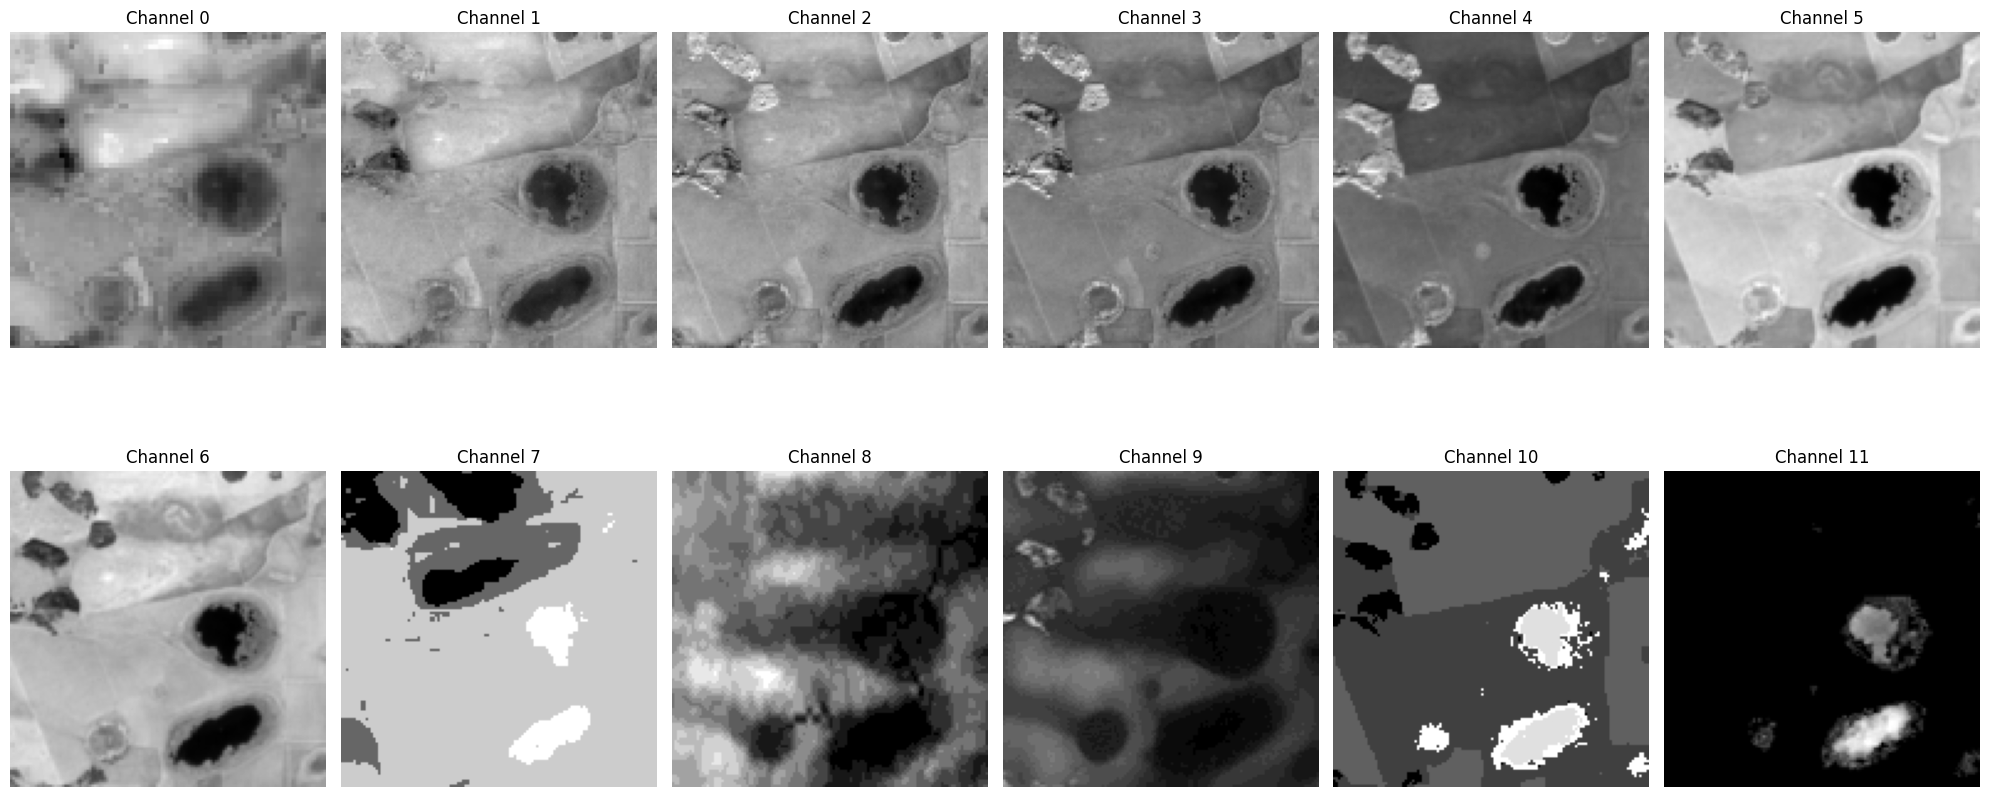

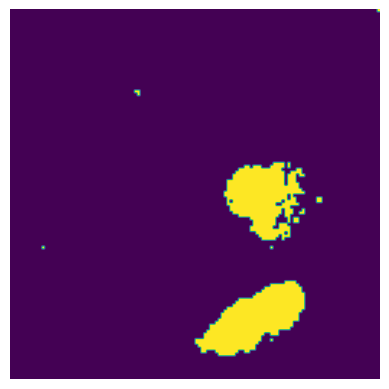

In [11]:
def display_images(file_path):
    ds = gdal.Open(file_path).ReadAsArray()

    fig, axes = plt.subplots(2, 6, figsize=(20, 10))
    axes = axes.flatten()

    # Plot each channel
    for i in range(12):
        ax = axes[i]
        channel_img = ds[i, :, :]
        im = ax.imshow(channel_img, cmap='gray')
        ax.set_title(f'Channel {i}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    
# Display the image
file_path = '/kaggle/input/satellite-data/data/images/10.tif'
display_images(file_path)

# Display the label
img = mpimg.imread('/kaggle/input/satellite-data/data/labels/10.png')
plt.imshow(img)
plt.axis('off')
plt.show()

# Preprocessing

**Min-Max normalization**

In [12]:
def scale_images(images):
    scaler = MinMaxScaler()
    scaled_images = np.zeros_like(images, dtype=np.float32)
    num_images = images.shape[0]

    for i in range(num_images):
        img = images[i].reshape(-1, 1)  # Flatten the image
        img_scaled = scaler.fit_transform(img).reshape(images[i].shape)  # Scale and reshape back
        scaled_images[i] = img_scaled
    
    return scaled_images

def binarize_labels(labels):
    binarized_labels = (labels > 0).astype(np.float32)  # Convert to binary (0 or 1)
    return to_categorical(binarized_labels, num_classes=2)  # One-hot encode the labels

In [13]:
# Apply scaling and binarization
scaled_images = scale_images(images)
scaled_labels = binarize_labels(labels)

**Splitting data into Validation and Testing**

In [14]:
# Split into training and test sets with 20% of data (244 train, 62 test)
train_images, test_images, train_labels, test_labels = train_test_split(
    scaled_images, scaled_labels, test_size=0.2, random_state=42
)

# Split into training and validation sets with 20% of data (195 train, 49 validation)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Pack validation and test sets
validation_data = (val_images, val_labels)
test_data = (test_images, test_labels)

# Convert to PyTorch tensors

In [15]:
train_images_tensor = torch.tensor(train_images).float()
train_labels_tensor = torch.tensor(train_labels).float()
val_images_tensor = torch.tensor(val_images).float()
val_labels_tensor = torch.tensor(val_labels).float()
test_images_tensor = torch.tensor(test_images).float()
test_labels_tensor = torch.tensor(test_labels).float()

# Create DataLoaders
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Torch Model

In [16]:
class DeepLabV3(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepLabV3, self).__init__()
        self.deeplab = segmentation.deeplabv3_resnet50(pretrained=True)
        self.deeplab.backbone.conv1 = nn.Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        in_channels = self.deeplab.classifier[4].in_channels
        self.deeplab.classifier[4] = nn.Conv2d(in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.deeplab(x)['out']
        return self.dropout(x)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepLabV3(num_classes=2).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 181MB/s]  


# Focal Loss Multi-Class

In [18]:
class FocalLossMultiClass(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, num_classes=2):
        super(FocalLossMultiClass, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes

    def forward(self, inputs, targets):
        # Apply softmax to the model outputs
        inputs = nn.functional.softmax(inputs, dim=1)
        
        # Check the size of inputs and targets before applying one-hot encoding
        assert inputs.size(1) == self.num_classes, f"Expected {self.num_classes} classes, but got {inputs.size(1)}"

        # Ensure targets are in index format
        if targets.dim() == 4:  # If targets are one-hot encoded
            targets = targets.argmax(dim=1)  # Convert to class indices

        # One-hot encode the targets if necessary
        targets_one_hot = nn.functional.one_hot(targets, num_classes=self.num_classes).float()  # Shape: (batch_size, height, width, num_classes)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2)  # Shape: (batch_size, num_classes, height, width)

        # Compute the binary cross-entropy loss
        BCE_loss = nn.functional.binary_cross_entropy(inputs, targets_one_hot, reduction='none')
        pt = torch.exp(-BCE_loss)

        # Compute the focal loss
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        return F_loss.mean()  # Return the mean loss

# Model compiler

In [19]:
# Initialize model, optimizer, and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Adjusted learning rate
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True, min_lr=1e-6)


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Model training

In [20]:
focal_loss_fn = FocalLossMultiClass(num_classes=2)

# Early stopping and other hyperparameters
num_epochs = 60
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
early_stopping_counter = 0  # Counter for early stopping

# Lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0 
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients

        images = images.permute(0, 3, 1, 2).to(device)  # Shape: (batch_size, 12, 128, 128)
        outputs = model(images)  # Get the model outputs, expected shape: (batch_size, 2, 128, 128)

        labels = labels.permute(0, 3, 1, 2).to(device)  # Shape: (batch_size, 2, 128, 128)
        class_indices = labels.argmax(dim=1)  # Shape: (batch_size, 128, 128)

        class_indices_one_hot = nn.functional.one_hot(class_indices, num_classes=2).float().permute(0, 3, 1, 2)  # One-hot encode

        loss = focal_loss_fn(outputs, class_indices_one_hot)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item() * images.size(0)  # Accumulate loss

        _, predicted = torch.max(outputs.data, 1)  # Get class predictions
        correct += (predicted == class_indices).sum().item()  # Count correct predictions
        total += class_indices.numel()  # Total number of pixels

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total  # Calculate training accuracy

    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for val_images, val_labels in val_loader:
            val_images = val_images.permute(0, 3, 1, 2).to(device)
            val_outputs = model(val_images)

            val_labels = val_labels.permute(0, 3, 1, 2).to(device)
            val_class_indices = val_labels.argmax(dim=1)

            val_loss += focal_loss_fn(val_outputs, nn.functional.one_hot(val_class_indices, num_classes=2).float().permute(0, 3, 1, 2)).item() * val_images.size(0)

            _, val_predicted = torch.max(val_outputs.data, 1)
            val_correct += (val_predicted == val_class_indices).sum().item()
            val_total += val_class_indices.numel()

    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Model saved!")
        early_stopping_counter = 0  # Reset counter
    else:
        early_stopping_counter += 1  # Increment counter
        if early_stopping_counter >= patience:
            print("Early stopping activated.")
            break

    lr_scheduler.step(val_loss)


Epoch [1/60], Train Loss: 0.2082, Train Accuracy: 57.32%
Epoch [1/60], Validation Loss: 0.2935, Validation Accuracy: 31.14%
Model saved!
Epoch [2/60], Train Loss: 0.1405, Train Accuracy: 77.14%
Epoch [2/60], Validation Loss: 0.2788, Validation Accuracy: 51.89%
Model saved!
Epoch [3/60], Train Loss: 0.1161, Train Accuracy: 84.18%
Epoch [3/60], Validation Loss: 0.1280, Validation Accuracy: 75.84%
Model saved!
Epoch [4/60], Train Loss: 0.1089, Train Accuracy: 84.15%
Epoch [4/60], Validation Loss: 0.0961, Validation Accuracy: 85.08%
Model saved!
Epoch [5/60], Train Loss: 0.1041, Train Accuracy: 85.25%
Epoch [5/60], Validation Loss: 0.0883, Validation Accuracy: 83.90%
Model saved!
Epoch [6/60], Train Loss: 0.0999, Train Accuracy: 85.26%
Epoch [6/60], Validation Loss: 0.0841, Validation Accuracy: 87.40%
Model saved!
Epoch [7/60], Train Loss: 0.0971, Train Accuracy: 85.86%
Epoch [7/60], Validation Loss: 0.0908, Validation Accuracy: 86.99%
Epoch [8/60], Train Loss: 0.0939, Train Accuracy: 86.0

**Remove output**

In [21]:
# if os.path.exists('best_model.pth'):
#     os.remove('best_model.pth')

# Testing

**Test dataset**

In [22]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
test_samples = 0

with torch.no_grad():  # Disable gradient calculation
    for test_images, test_labels in test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_images = test_images.permute(0, 3, 1, 2)  # Shape to (batch_size, 12, 128, 128)
        
        test_outputs = model(test_images)  # Get model predictions

        # Permute test labels to (batch_size, num_classes, height, width)
        test_labels = test_labels.permute(0, 3, 1, 2)  # Change to (batch_size, 2, 128, 128)

        # Calculate loss using the focal loss function
        class_indices = test_labels.argmax(dim=1)  # Get class indices from labels
        class_indices_one_hot = nn.functional.one_hot(class_indices, num_classes=2).float()  # One-hot encode
        class_indices_one_hot = class_indices_one_hot.permute(0, 3, 1, 2)  # Shape to (batch_size, 2, 128, 128)

        # Calculate loss
        loss = focal_loss_fn(test_outputs, class_indices_one_hot)  # Calculate loss
        test_loss += loss.item()  # Accumulate loss

        # Calculate accuracy
        test_predicted = torch.argmax(test_outputs, dim=1)  # Get the predicted class
        test_true_labels = torch.argmax(test_labels, dim=1)  # Get the true class

        # Calculate correct predictions
        test_correct += (test_predicted == test_true_labels).sum().item()  # Count correct predictions
        test_samples += test_true_labels.numel()  # Total number of elements in test labels

# Average test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / test_samples * 100
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.0528, Test Accuracy: 91.48%


# Model statistics Visualization
# Training and Validation Accuracy

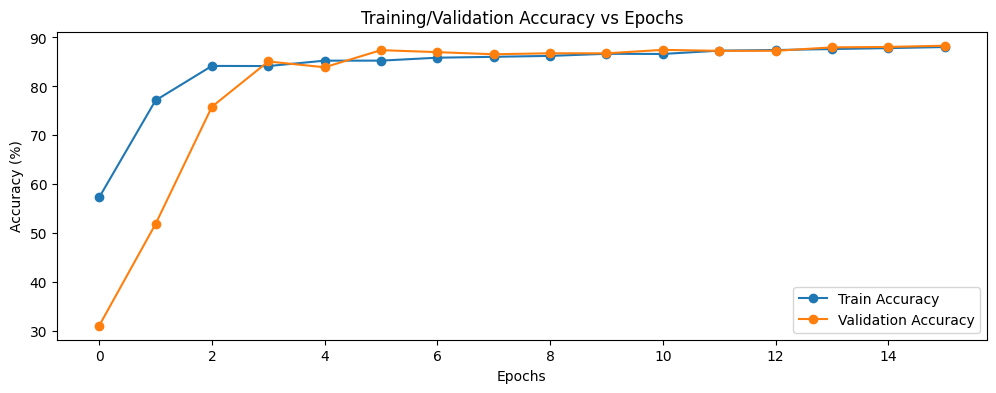

In [23]:
# Plot training and validation accuracy
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.set_title('Training/Validation Accuracy vs Epochs')
ax.plot(train_accuracies, 'o-', label='Train Accuracy')
ax.plot(val_accuracies, 'o-', label='Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy (%)')
ax.legend(loc='best')
plt.show()

# Training and Validation Loss

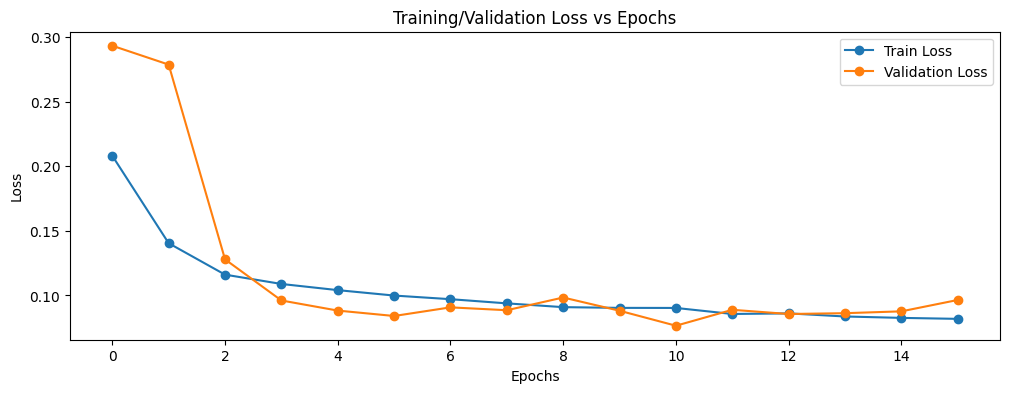

In [24]:
# Plot training and validation losses
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.set_title('Training/Validation Loss vs Epochs')
ax.plot(train_losses, 'o-', label='Train Loss')
ax.plot(val_losses, 'o-', label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(loc='best')
plt.show()

# Calcualte predictions

In [25]:
def get_predictions_and_labels(images, labels):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        # Ensure images are a tensor and move to the correct device
        if isinstance(images, torch.Tensor):
            images = images.to(device)
        else:
            images = torch.from_numpy(images).float().to(device)
        
        # Forward pass to get predictions
        outputs = model(images)
        
        # Convert one-hot encoded labels to class indices
        if isinstance(labels, torch.Tensor):
            labels = labels.cpu().numpy()  # Move to CPU and convert to numpy

        # Convert labels from one-hot encoding (shape: (14, 2, 128, 128)) to class indices (shape: (14, 128, 128))
        if labels.ndim == 4:
            labels = np.argmax(labels, axis=1)  # Now shape is (14, 128, 128)

        # Convert predictions from one-hot encoded to class indices
        batch_preds = torch.argmax(outputs, dim=1).cpu().numpy()  # Now shape is (14, 128, 128)

        # Flatten and collect all predictions and labels
        all_labels.extend(labels.flatten())
        all_preds.extend(batch_preds.flatten())
    
    return np.array(all_labels), np.array(all_preds)

# Display Confusion Matrix

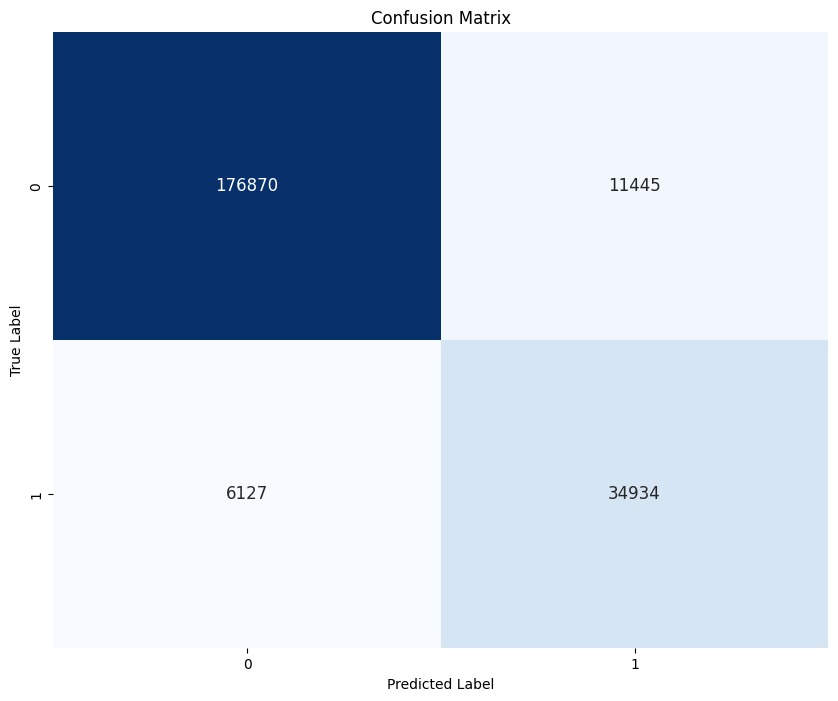

In [26]:
# Get true labels and predictions
y_true, y_pred = get_predictions_and_labels(test_images, test_labels)

# Compute the confusion matrix
cf_mtx = confusion_matrix(y_true, y_pred)

# Create a DataFrame for better plotting
class_labels = [str(i) for i in range(2)]  # Adjust if you have more classes
cf_df = pd.DataFrame(cf_mtx, index=class_labels, columns=class_labels)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cf_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 12})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Display predictions

In [27]:
def predict_and_process(model, images):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        # Check if images is a tensor; if not, convert to tensor
        if isinstance(images, torch.Tensor):
            images_tensor = images.to(device)
        else:
            images_tensor = torch.from_numpy(images).float().to(device)
        
        # Get predictions from the model
        outputs = model(images_tensor)

        # Apply softmax to get probabilities and convert to binary (0 or 1)
        probabilities = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes, height, width)
        processed_preds = (probabilities > 0.5).float()  # Binarize predictions
        processed_preds = processed_preds.cpu().numpy()  # Move to CPU and convert to numpy

        # Optionally multiply by 255 to unnormalize if needed
        processed_preds = processed_preds * 255

    return processed_preds

In [28]:
def display_predictions(predictions, labels=None, batch_size=5, num_to_display=10):
    num_images = min(len(predictions), num_to_display)
    cols = 2

    for batch_start in range(0, num_images, batch_size):
        batch_end = min(batch_start + batch_size, num_images)

        plt.figure(figsize=(8, batch_size * 3))

        for i in range(batch_start, batch_end):
            batch_idx = i - batch_start

            # Convert multi-channel predictions to a binary mask
            if predictions[i].ndim == 3 and predictions[i].shape[0] == 2:
                pred_mask = np.argmax(predictions[i], axis=0)  # Convert to single-channel
            else:
                pred_mask = predictions[i]

            # Ensure pred_mask is a 2D array
            pred_mask = pred_mask.squeeze()  # Remove any single-dimensional entries

            # Display the predicted binary mask
            plt.subplot(batch_size, cols, batch_idx * cols + 1)
            plt.imshow(pred_mask, cmap='gray')
            plt.title('Predicted Image')
            plt.axis('off')

            if labels is not None:
                # Move labels to CPU if they are on GPU
                if isinstance(labels, torch.Tensor):
                    label_mask = labels[i].cpu().numpy()  # Ensure labels are on CPU
                else:
                    label_mask = labels[i]

                # Convert multi-channel labels to a single-channel mask if necessary
                if label_mask.ndim == 3 and label_mask.shape[0] == 2:
                    label_mask = np.argmax(label_mask, axis=0)  # Convert to single-channel

                label_mask = label_mask.squeeze()  # Remove any single-dimensional entries

                plt.subplot(batch_size, cols, batch_idx * cols + 2)
                plt.imshow(label_mask, cmap='gray')
                plt.title('Label Image')
                plt.axis('off')

        plt.tight_layout()
        plt.show()


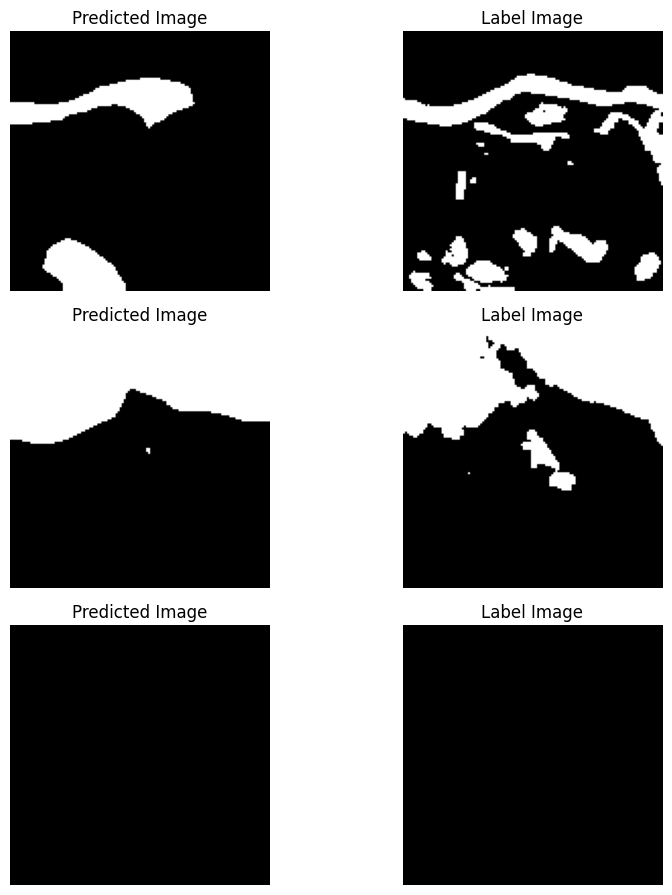

In [29]:
# Usage example
processed_preds = predict_and_process(model, images)
display_predictions(processed_preds, labels, batch_size=5, num_to_display=10)

# Classification report

In [30]:
report = classification_report(y_true, y_pred, target_names=class_labels, zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95    188315
           1       0.75      0.85      0.80     41061

    accuracy                           0.92    229376
   macro avg       0.86      0.90      0.88    229376
weighted avg       0.93      0.92      0.93    229376

